# Some imports and functions to split the data

In [160]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

def load_spotify_data():
    return pd.read_csv(os.path.join('data', '278_labelled_uri_train.csv'))

def split_data(df):
    spotify_train, spotify_test = train_test_split(df, test_size=0.2, random_state=42)
    spotify_train_features = spotify_train.drop('labels', axis=1)
    spotify_train_label = spotify_train['labels']
    spotify_test_features = spotify_test.drop('labels', axis=1)
    spotify_test_label = spotify_test['labels']
    return spotify_train_features, spotify_train_label, spotify_test_features, spotify_test_label

def rename_labels(df):
    df.loc[df == 0] = '0 (sad)'
    df.loc[df == 1] = '1 (happy)'
    df.loc[df == 2] = '2 (energetic)'
    df.loc[df == 3] = '3 (calm)'
    return df

def eval(model, X_train, X_test, y_train, y_test):
    print('TEST')
    y_test_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.show()
    print("-------------------------------------------------------")
    print('TRAIN')
    y_train_pred = model.predict(X_train)
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    print("-------------------------------------------------------")

def get_eval_scores(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    score_train = f1_score(y_train, y_train_pred, average='weighted')
    score_test = f1_score(y_test, y_test_pred, average='weighted')
    return score_train, score_test

def drop_columns(cols_to_drop, df_train, df_val):
    df_train.drop(columns=cols_to_drop, inplace=True)
    df_val.drop(columns=cols_to_drop, inplace=True)

def correct_wrong_predicted_sets(model, X, y):
    final_predictions = model.predict(X)
    df = X.copy()
    df["label"] = y
    df["label_predicted"] = final_predictions
    return df[df['label'] == df['label_predicted']], df[df['label'] != df['label_predicted']]

def print_what_predicted_wrongly(label_name):
    print("predicted wrong for", label_name)
    print(incorrect[incorrect['label'] == label_name]['label_predicted'].value_counts(normalize=True))

def print_what_it_should_be(label_name):
    print(label_name, "was predicted, but should be")
    print(incorrect[incorrect['label_predicted'] == label_name]['label'].value_counts(normalize=True))

# Load the data and split it

In [161]:
spotify_data_original = load_spotify_data()
X_train, y_train, X_test, y_test = split_data(spotify_data_original)
rename_labels(y_train)
rename_labels(y_test)

# columns_to_drop = ["uri", "Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2", "duration (ms)", "speechiness", "liveness", "tempo", "spec_rate"]

# drop_columns(["uri", "Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2", "duration (ms)", "speechiness", "liveness", "tempo", "spec_rate"], X_train, X_test)
drop_columns(["uri", "Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2"], X_train, X_test)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177880 entries, 199972 to 121958
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration (ms)     177880 non-null  float64
 1   danceability      177880 non-null  float64
 2   energy            177880 non-null  float64
 3   loudness          177880 non-null  float64
 4   speechiness       177880 non-null  float64
 5   acousticness      177880 non-null  float64
 6   instrumentalness  177880 non-null  float64
 7   liveness          177880 non-null  float64
 8   valence           177880 non-null  float64
 9   tempo             177880 non-null  float64
 10  spec_rate         177880 non-null  float64
dtypes: float64(11)
memory usage: 16.3 MB


# SDGClassifier

TEST
[[ 9364  2564   407   803]
 [ 1447 14689   828   156]
 [  127  2462  4976    37]
 [  155   124    10  6321]]
               precision    recall  f1-score   support

      0 (sad)       0.84      0.71      0.77     13138
    1 (happy)       0.74      0.86      0.79     17120
2 (energetic)       0.80      0.65      0.72      7602
     3 (calm)       0.86      0.96      0.91      6610

     accuracy                           0.79     44470
    macro avg       0.81      0.80      0.80     44470
 weighted avg       0.80      0.79      0.79     44470



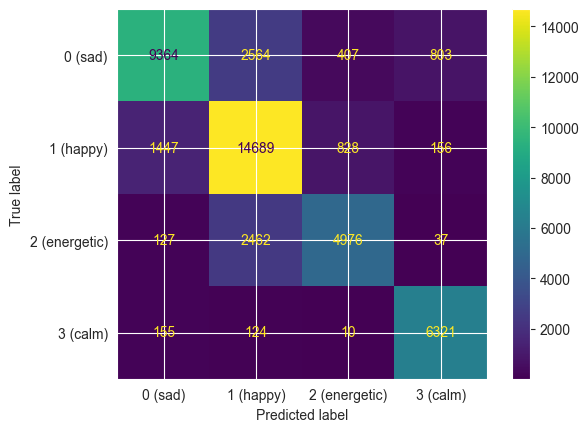

-------------------------------------------------------
TRAIN
[[37524 10151  1683  3090]
 [ 5459 58500  3417   629]
 [  521  9744 19707   103]
 [  639   453    51 26209]]
               precision    recall  f1-score   support

      0 (sad)       0.85      0.72      0.78     52448
    1 (happy)       0.74      0.86      0.80     68005
2 (energetic)       0.79      0.66      0.72     30075
     3 (calm)       0.87      0.96      0.91     27352

     accuracy                           0.80    177880
    macro avg       0.81      0.80      0.80    177880
 weighted avg       0.80      0.80      0.80    177880

-------------------------------------------------------


In [162]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sdg_pipeline = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=0.01))

sdg_pipeline.fit(X_train, y_train)

eval(sdg_pipeline, X_train, X_test, y_train, y_test)

In [163]:
correct, incorrect = correct_wrong_predicted_sets(sdg_pipeline, X_test, y_test)
incorrect

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,label,label_predicted
146896,259360.0,0.515,0.489,-10.021,0.0323,0.239000,0.901000,0.0736,0.683,106.960,1.245373e-07,3 (calm),1 (happy)
159538,273067.0,0.616,0.510,-7.994,0.0323,0.289000,0.000000,0.1040,0.193,119.973,1.182860e-07,1 (happy),0 (sad)
191713,347459.0,0.785,0.928,-6.253,0.0834,0.000485,0.241000,0.0316,0.540,122.000,2.400283e-07,2 (energetic),1 (happy)
44309,240000.0,0.571,0.972,-6.313,0.0921,0.071900,0.016600,0.0920,0.430,170.014,3.837500e-07,1 (happy),2 (energetic)
61227,204290.0,0.422,0.471,-8.784,0.1800,0.142000,0.000000,0.1120,0.620,82.433,8.811004e-07,1 (happy),0 (sad)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141387,185760.0,0.622,0.934,-2.828,0.1050,0.012700,0.000000,0.1600,0.920,163.955,5.652455e-07,2 (energetic),1 (happy)
171727,191432.0,0.447,0.634,-5.126,0.0924,0.892000,0.000009,0.0720,0.449,124.232,4.826779e-07,1 (happy),0 (sad)
185167,237067.0,0.539,0.677,-9.229,0.0269,0.013600,0.429000,0.2090,0.597,105.007,1.134700e-07,0 (sad),1 (happy)
100551,352080.0,0.383,0.273,-17.004,0.0310,0.910000,0.774000,0.0986,0.555,88.957,8.804817e-08,0 (sad),3 (calm)


## SDGClassifier: Incorrect predictions: Show what should have been predicted instead

In [164]:
correct, incorrect = correct_wrong_predicted_sets(sdg_pipeline, X_test, y_test)

incorrect['label'].value_counts(normalize=True)

label
0 (sad)          0.413816
2 (energetic)    0.287939
1 (happy)        0.266557
3 (calm)         0.031689
Name: proportion, dtype: float64

## SDGClassifier: Incorrect predictions: Show what was predicted incorrectly

In [165]:
correct, incorrect = correct_wrong_predicted_sets(sdg_pipeline, X_test, y_test)

incorrect['label_predicted'].value_counts(normalize=True)

label_predicted
1 (happy)        0.564693
0 (sad)          0.189583
2 (energetic)    0.136513
3 (calm)         0.109211
Name: proportion, dtype: float64

## SDGClassifier: Show it a bit more detailed

In [166]:
correct, incorrect = correct_wrong_predicted_sets(sdg_pipeline, X_test, y_test)

print("--------------------")
print("What is the actual label, but what was predicted instead:")
print_what_predicted_wrongly('0 (sad)')
print_what_predicted_wrongly('1 (happy)')
print_what_predicted_wrongly('2 (energetic)')
print_what_predicted_wrongly('3 (calm)')


print("--------------------")
print("What was predicted, but what it should be:")
print_what_it_should_be('0 (sad)')
print_what_it_should_be('1 (happy)')
print_what_it_should_be('2 (energetic)')
print_what_it_should_be('3 (calm)')

--------------------
What is the actual label, but what was predicted instead:
predicted wrong for 0 (sad)
label_predicted
1 (happy)        0.679385
3 (calm)         0.212772
2 (energetic)    0.107843
Name: proportion, dtype: float64
predicted wrong for 1 (happy)
label_predicted
0 (sad)          0.595228
2 (energetic)    0.340601
3 (calm)         0.064171
Name: proportion, dtype: float64
predicted wrong for 2 (energetic)
label_predicted
1 (happy)    0.937548
0 (sad)      0.048363
3 (calm)     0.014090
Name: proportion, dtype: float64
predicted wrong for 3 (calm)
label_predicted
0 (sad)          0.536332
1 (happy)        0.429066
2 (energetic)    0.034602
Name: proportion, dtype: float64
--------------------
What was predicted, but what it should be:
0 (sad) was predicted, but should be
label
1 (happy)        0.836900
3 (calm)         0.089647
2 (energetic)    0.073453
Name: proportion, dtype: float64
1 (happy) was predicted, but should be
label
0 (sad)          0.497864
2 (energetic)  

# Random forest (with StandardScaler)

TEST
[[12432   496    74   136]
 [  424 16239   437    20]
 [   81   733  6785     3]
 [  131    44     3  6432]]
               precision    recall  f1-score   support

      0 (sad)       0.95      0.95      0.95     13138
    1 (happy)       0.93      0.95      0.94     17120
2 (energetic)       0.93      0.89      0.91      7602
     3 (calm)       0.98      0.97      0.97      6610

     accuracy                           0.94     44470
    macro avg       0.95      0.94      0.94     44470
 weighted avg       0.94      0.94      0.94     44470



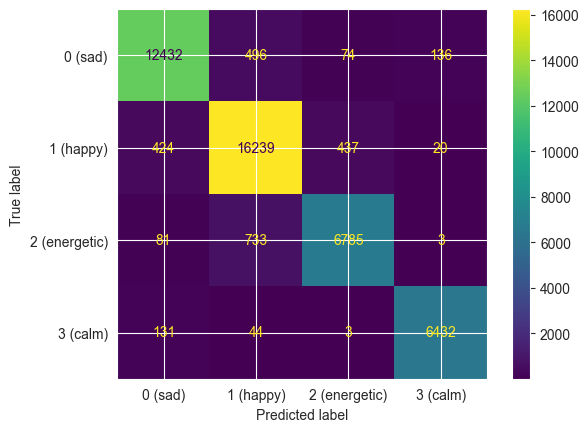

-------------------------------------------------------
TRAIN
[[52448     0     0     0]
 [    0 68005     0     0]
 [    0     1 30074     0]
 [    0     0     0 27352]]
               precision    recall  f1-score   support

      0 (sad)       1.00      1.00      1.00     52448
    1 (happy)       1.00      1.00      1.00     68005
2 (energetic)       1.00      1.00      1.00     30075
     3 (calm)       1.00      1.00      1.00     27352

     accuracy                           1.00    177880
    macro avg       1.00      1.00      1.00    177880
 weighted avg       1.00      1.00      1.00    177880

-------------------------------------------------------


In [167]:
from sklearn.ensemble import RandomForestClassifier

random_forest_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))

random_forest_pipeline.fit(X_train, y_train)

eval(random_forest_pipeline, X_train, X_test, y_train, y_test)

### Since energetic have the lowest recall (= highest false negatives), lets look at some examples:

In [180]:
correct, incorrect = correct_wrong_predicted_sets(random_forest_pipeline, X_test, y_test)
incorrect_energetics = incorrect[incorrect['label'] == '2 (energetic)']
print(incorrect_energetics.head(1))
spotify_data_original.loc[incorrect_energetics.head(1).index]

        duration (ms)  danceability  energy  loudness  speechiness  \
221280       335197.0         0.793   0.738   -10.611       0.0712   

        acousticness  instrumentalness  liveness  valence    tempo  \
221280        0.0163             0.917      0.12   0.0379  126.999   

           spec_rate          label label_predicted  
221280  2.124124e-07  2 (energetic)       1 (happy)  


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels,uri
221280,55337,55337,55337,335197.0,0.793,0.738,-10.611,0.0712,0.0163,0.917,0.12,0.0379,126.999,2.124124e-07,2,spotify:track:5X1240MFuB9KH76QxSCSBd


## Random forest with GridSearchCV / Hyperparameter

In [182]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    # 'max_depth': [80],
    'max_features': [4, 5],
    # 'min_samples_leaf': [3],
    # 'min_samples_split': [8],
    # 'n_estimators': [100]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=42), param_grid = param_grid, n_jobs = -1, verbose = 4, cv = 3)

grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 2 candidates, totalling 6 fits


{'bootstrap': True, 'max_features': 4}

TEST
[[12348   544   104   142]
 [  439 16154   500    27]
 [   78   759  6761     4]
 [  137    49     4  6420]]
               precision    recall  f1-score   support

      0 (sad)       0.95      0.94      0.94     13138
    1 (happy)       0.92      0.94      0.93     17120
2 (energetic)       0.92      0.89      0.90      7602
     3 (calm)       0.97      0.97      0.97      6610

     accuracy                           0.94     44470
    macro avg       0.94      0.94      0.94     44470
 weighted avg       0.94      0.94      0.94     44470



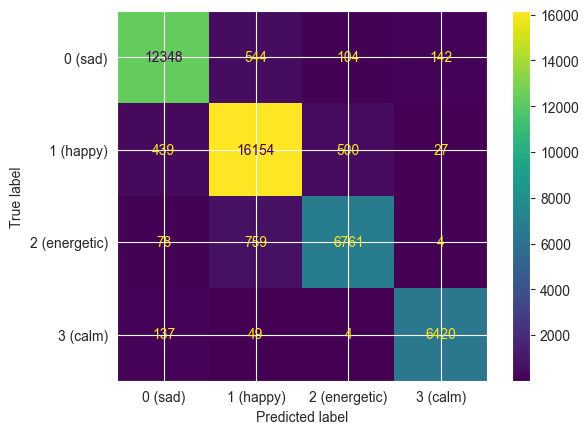

-------------------------------------------------------
TRAIN
[[52448     0     0     0]
 [    0 68005     0     0]
 [    0     1 30074     0]
 [    0     0     0 27352]]
               precision    recall  f1-score   support

      0 (sad)       1.00      1.00      1.00     52448
    1 (happy)       1.00      1.00      1.00     68005
2 (energetic)       1.00      1.00      1.00     30075
     3 (calm)       1.00      1.00      1.00     27352

     accuracy                           1.00    177880
    macro avg       1.00      1.00      1.00    177880
 weighted avg       1.00      1.00      1.00    177880

-------------------------------------------------------


In [184]:
best_grid = grid_search.best_estimator_
eval(best_grid, X_train, X_test, y_train, y_test)

## Random Forest: Reduce overfitting

In [173]:
from sklearn.ensemble import RandomForestClassifier

scores_test = []
scores_train = []

n_estimators_to_check = [1, 10, 20, 40, 80, 160, 300]

for i in n_estimators_to_check:
    print("n_estimators:", i)
    random_forest_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=i, random_state=42))
    random_forest_pipeline.fit(X_train, y_train)
    score_train, score_test = get_eval_scores(random_forest_pipeline, X_train, X_test, y_train, y_test)
    print("score_train:", score_train)
    print("score_test:", score_test)
    scores_train.append(score_train)
    scores_test.append(score_test)

print("scores_train")
print(scores_train)
print("scores_test")
print(scores_test)

n_estimators: 1
score_train: 0.9517195969758389
score_test: 0.8690421242180875
n_estimators: 10
score_train: 0.9972441077002517
score_test: 0.9273488021673696
n_estimators: 20
score_train: 0.9994377715687035
score_test: 0.935713079508381
n_estimators: 40
score_train: 0.9999156730491462
score_test: 0.9396695828600014
n_estimators: 80
score_train: 1.0
score_test: 0.9415297537755041
n_estimators: 160
score_train: 1.0
score_test: 0.9422726612833789
n_estimators: 300
score_train: 1.0
score_test: 0.9421699730154774
scores_train
[0.9517195969758389, 0.9972441077002517, 0.9994377715687035, 0.9999156730491462, 1.0, 1.0, 1.0]
scores_test
[0.8690421242180875, 0.9273488021673696, 0.935713079508381, 0.9396695828600014, 0.9415297537755041, 0.9422726612833789, 0.9421699730154774]


This means that the sweet spot is somewhere between 160 and 300 estimators. Lets try 200.

TEST
[[12434   500    73   131]
 [  402 16253   445    20]
 [   82   711  6805     4]
 [  129    52     4  6425]]
               precision    recall  f1-score   support

      0 (sad)       0.95      0.95      0.95     13138
    1 (happy)       0.93      0.95      0.94     17120
2 (energetic)       0.93      0.90      0.91      7602
     3 (calm)       0.98      0.97      0.97      6610

     accuracy                           0.94     44470
    macro avg       0.95      0.94      0.94     44470
 weighted avg       0.94      0.94      0.94     44470



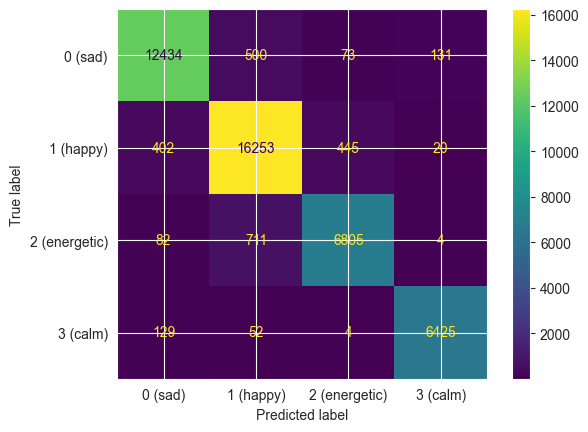

-------------------------------------------------------
TRAIN
[[52448     0     0     0]
 [    0 68005     0     0]
 [    0     0 30075     0]
 [    0     0     0 27352]]
               precision    recall  f1-score   support

      0 (sad)       1.00      1.00      1.00     52448
    1 (happy)       1.00      1.00      1.00     68005
2 (energetic)       1.00      1.00      1.00     30075
     3 (calm)       1.00      1.00      1.00     27352

     accuracy                           1.00    177880
    macro avg       1.00      1.00      1.00    177880
 weighted avg       1.00      1.00      1.00    177880

-------------------------------------------------------


In [183]:
from sklearn.ensemble import RandomForestClassifier

random_forest_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42, n_estimators=200))

random_forest_pipeline.fit(X_train, y_train)

eval(random_forest_pipeline, X_train, X_test, y_train, y_test)

/var/folders/2_/k0k0kb951ng8_mpf1lmz5h2c0000gn/T/ipykernel_3496/2253538976.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df == 0] = '0 (sad)'
/var/folders/2_/k0k0kb951ng8_mpf1lmz5h2c0000gn/T/ipykernel_3496/2253538976.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df == 1] = '1 (happy)'
/var/folders/2_/k0k0kb951ng8_mpf1lmz5h2c0000gn/T/ipykernel_3496/2253538976.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[[64882   500    73   131]
 [  402 84258   445    20]
 [   82   711 36880     4]
 [  129    52     4 33777]]
               precision    recall  f1-score   support

      0 (sad)       0.99      0.99      0.99     65586
    1 (happy)       0.99      0.99      0.99     85125
2 (energetic)       0.99      0.98      0.98     37677
     3 (calm)       1.00      0.99      0.99     33962

     accuracy                           0.99    222350
    macro avg       0.99      0.99      0.99    222350
 weighted avg       0.99      0.99      0.99    222350



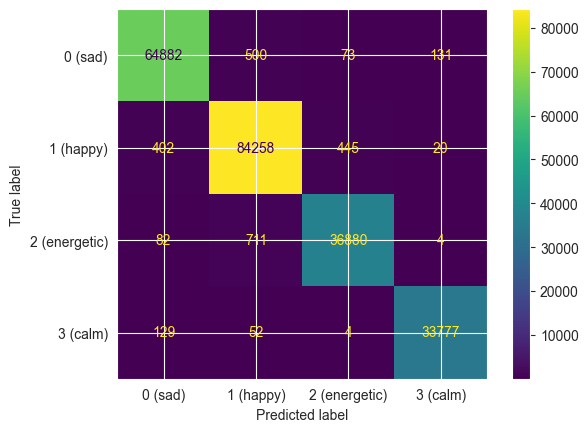

In [189]:
spotify_data_test_original = pd.read_csv(os.path.join('data', '278_labelled_uri_train.csv'))

spotify_data_test = spotify_data_original.copy()

spotify_data_test.loc[spotify_data_test['labels'] == 0, 'labels'] = '0 (sad)'
spotify_data_test.loc[spotify_data_test['labels'] == 1, 'labels'] = '1 (happy)'
spotify_data_test.loc[spotify_data_test['labels'] == 2, 'labels'] = '2 (energetic)'
spotify_data_test.loc[spotify_data_test['labels'] == 3, 'labels'] = '3 (calm)'

X_val = spotify_data_test.drop('labels', axis=1)
y_val = spotify_data_test['labels']

rename_labels(y_val)
X_val.drop(columns=["uri", "Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2"], inplace=True)

y_test_pred = random_forest_pipeline.predict(X_val)
print(confusion_matrix(y_val, y_test_pred))
print(classification_report(y_val, y_test_pred))
ConfusionMatrixDisplay.from_predictions(y_val, y_test_pred)
plt.show()


In [190]:
print(random_forest_pipeline.score(X_val, y_val))


0.9885181020912975
